In [316]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
from prophet import Prophet
from numpy import mean, max, maximum, quantile
from numpy import std
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

In [317]:
DELTA = 40
AGG = 20
FREQ = str(AGG) + 'min'

In [318]:
transactions = pd.read_csv('transactions.csv', header=0, index_col=0)
df = transactions.drop(['Value'], axis=1)
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df = df.groupby(pd.Grouper(level='Date', freq=FREQ)).mean()

In [319]:
start_date = datetime.combine(date(2021, 10, 16), time(3,0)) 
end_date = datetime.combine(date(2021, 10, 17), time(6,0))

start_date, end_date

(datetime.datetime(2021, 10, 16, 3, 0), datetime.datetime(2021, 10, 17, 6, 0))

In [320]:
df = df.reset_index()

In [321]:
def y_lims(df, col_name):
    data_mean, data_std = mean(df[col_name]), std(df[col_name])
    cut_off = data_std * 5
    return data_mean - cut_off, data_mean + cut_off   

def cut_off(df, col_name):
    data_mean, data_std = mean(df[col_name]), std(df[col_name])
    cut_off = data_std * 4
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # print(data_mean, data_std, lower, upper)
    for index,row in df.iterrows():
        if row[col_name] < lower:
            row[col_name]=lower
        elif row[col_name] > upper:
            row[col_name]=upper

In [322]:
df.rename(columns = {'Date':'ds', 'Price': 'y'}, inplace=True)

In [324]:
m = Prophet(changepoint_prior_scale=0.0005,yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True, interval_width=0.30)
m.fit(df)

/home/andras/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [325]:
future = m.make_future_dataframe(periods=100, freq=FREQ)

In [326]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


/home/andras/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/andras/.local/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
21047,2021-10-20 07:40:00,1.173936e+11,7.971935e+10,1.527402e+11
21048,2021-10-20 08:00:00,1.188005e+11,8.656533e+10,1.454906e+11
21049,2021-10-20 08:20:00,1.202216e+11,9.159656e+10,1.526523e+11
21050,2021-10-20 08:40:00,1.214966e+11,9.272350e+10,1.482436e+11
21051,2021-10-20 09:00:00,1.225002e+11,9.236426e+10,1.585840e+11


Text(72.625, 0.5, 'y, y_hat')

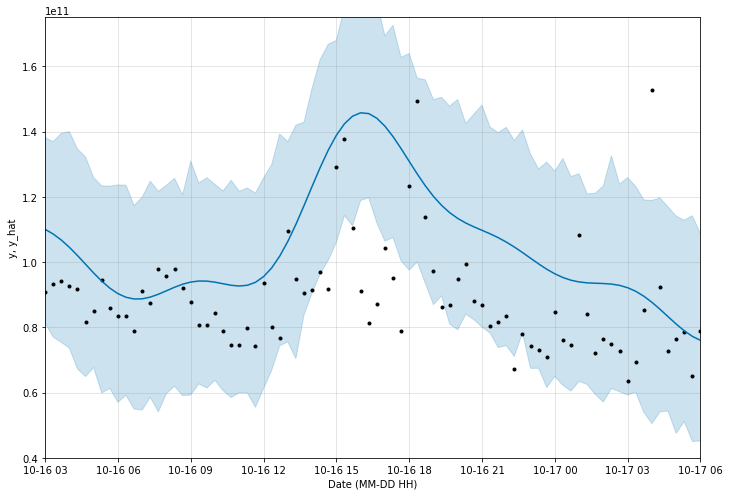

In [327]:
fig = m.plot(forecast, figsize=(10, 7))
ax = fig.gca()
ax.set_xlim([start_date, end_date])
ax.set_ylim(0.4e11, 1.75e11)
ax.set_xlabel('Date (MM-DD HH)')
ax.set_ylabel('y, y_hat')

In [328]:
real=np.array(df.y)
real=real.reshape(-1, 1)
real = real[-100:]
pred=np.array(forecast.yhat)
pred=pred.reshape(-1, 1)
pred = pred[-100:]

In [329]:
def quantile_loss(q, y, y_hat):
        e = y-y_hat
        return mean(maximum(q*e, (q-1)*e))

In [330]:
sc = MinMaxScaler(feature_range=(0,1))
real = sc.fit_transform(real)
pred = sc.transform(pred)

#Error Metrics On Test Set
print('prophet MAE : %.3f'%mean_absolute_error(real, pred))
print('prophet MSE: %.3f'%mean_squared_error(real, pred))
print('prophet R2-score : %.3f'%r2_score(real, pred))
print('prophet RMSE : %.3f'%sqrt(mean_squared_error(real, pred)))
print('quantile loss [0.10] : %.3f'%quantile_loss(0.1, real, pred))
print('quantile loss [0.50] : %.3f'%quantile_loss(0.3, real, pred))
print('quantile loss [0.90] : %.3f'%quantile_loss(0.9, real, pred))


# print('prophet NRMSE : %.3f'%sqrt(mean_squared_error(real, pred)))

prophet MAE : 0.035
prophet MSE: 0.010
prophet R2-score : -0.037
prophet RMSE : 0.102
quantile loss [0.10] : 0.020
quantile loss [0.50] : 0.019
quantile loss [0.90] : 0.014
